In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost
from gplearn.genetic import SymbolicRegressor

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from preprocess import *
from models import RobustPCANN

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

from pytorch_robust_pca import *

# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder

# Tracking
from tqdm import trange

import sympy
import sympytorch

Running Python 3.9.6
You can use npar for np.array


In [2]:
# Loading the KS sol
DATA_PATH = "../deephpms_data/KS_simple3.pkl"
data = pickle_load(DATA_PATH)
t = data['t']
x = data['x']
X, T = np.meshgrid(x, t)
Exact = data['u'].T
u_star = Exact.T.flatten()[:,None]

Loaded from ../deephpms_data/KS_simple3.pkl


In [3]:
# Adding noise
noise_intensity = 0.01
u_star_clean = u_star
noise = perturb(u_star, intensity=noise_intensity, noise_type="normal", overwrite=False)
u_star = u_star + noise
print("Perturbed u_star with intensity =", float(noise_intensity))

print("Running Robust PCA on u_star")
rpca = R_pca_numpy(u_star)
u_star_L, u_star_S = rpca.fit(tol=1e-16, max_iter=10000, iter_print=100, verbose=False)
print('Robust PCA Loss:', mean_squared_error(u_star, u_star_L+u_star_S))

Perturbed u_star with intensity = 0.01
Running Robust PCA on u_star
Robust PCA Loss: 1.462438343651258e-34


In [4]:
((noise-u_star_S)**2).mean()

0.7954330560811899

In [5]:
out, PSD = fft1d_denoise(to_tensor(u_star), thres=None, c=0)
out = out.detach().numpy()
PSD = PSD.detach().numpy()

In [6]:
((noise-(u_star-out))**2).mean()

0.0025763464225219868

In [7]:
import seaborn as sns

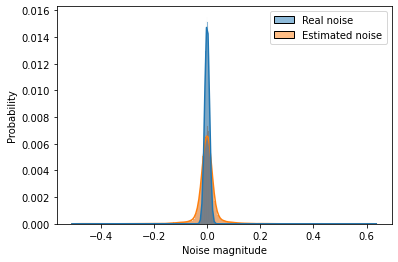

In [8]:
# noise_intensity = 0.01 -> Noise magitude ranges from -0.4 to around 0.6.
tmp = {"Real noise":noise.flatten(), "Estimated noise":(u_star-out).flatten()}
sns.histplot(tmp, kde=True, stat="probability")
plt.xlabel("Noise magnitude")
plt.show()

In [9]:
n_exps = 50
all_fftc0_noises = np.zeros((u_star_S.shape[0], n_exps))
all_fftc1_noises = np.zeros(all_fftc0_noises.shape)
# all_out_c1 = np.zeros(all_u_star_S.shape)
all_noises = np.zeros(all_fftc0_noises.shape)

Some goals + Notes
    
    - Is denoising using FFT better than the Robust PCA algo for init?: YES!
    - If so, what is the recommended c wrt the varied noise_intensity?: With noise_intensity = 10, the c=1 starts to perform better. So c=0 is quite good for a wide range of noises.
    
    - noise_intensity = 10 -> c=1 best, noise_intensity = 0.01 -> c=-1 best, noise_intensity = 1 -> c=0 best. If the medium level of noise is presumed, the c=0 is recommended starting point!
    
    - In practice, the c hyper-parameter can be easily tuned wrt to the the first-epochs loss.
    
    - Using fft is sometimes better than knowing only the noise dist.

In [10]:
for i in range(n_exps):
    print(i+1)
    # Adding noise
    noise_intensity = 1 # c=0 is better than c=1, -1 for noise_intensity = 1
    u_star = Exact.T.flatten()[:,None]
    noise = perturb(u_star, intensity=noise_intensity, noise_type="normal", overwrite=False)
    u_star = u_star + noise
    print("Perturbed u_star with intensity =", float(noise_intensity))
    all_noises[:, i:i+1] = noise

#     print("Running Robust PCA on u_star")
#     rpca = R_pca_numpy(u_star)
#     u_star_L, u_star_S = rpca.fit(tol=1e-16, max_iter=10000, iter_print=100, verbose=False)
#     all_u_star_S[:, i:i+1] = u_star_S
    
    print("Running FFT c=0 on u_star")
    out, PSD = fft1d_denoise(to_tensor(u_star), thres=None, c=0)
#     PSD = PSD.detach().numpy()
    all_fftc0_noises[:, i:i+1] = (u_star-out.detach().numpy())
    
    print("Running FFT c=1 on u_star")
    out, PSD = fft1d_denoise(to_tensor(u_star), thres=0, c=-1)
#     PSD = PSD.detach().numpy()
    all_fftc1_noises[:, i:i+1] = (u_star-out.detach().numpy())
    
    print()
    
print("DONE...")

1
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

2
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

3
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

4
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

5
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

6
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

7
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

8
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

9
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

10
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Running FFT c=1 on u_star

11
Perturbed u_star with intensity = 1.0
Running FFT c=0 on u_star
Ru

In [11]:
fftc0_mse = []
fftc1_mse = []
for i in range(n_exps):
    fftc0_mse.append(((all_noises[:, i:i+1]-all_fftc0_noises[:, i:i+1])**2).mean())
    fftc1_mse.append(((all_noises[:, i:i+1]-all_fftc1_noises[:, i:i+1])**2).mean())

In [12]:
from scipy.stats import ttest_ind

In [13]:
t_stat, p_val = ttest_ind(fftc0_mse, fftc1_mse, equal_var=False, alternative='less')
if p_val/2 < 0.05: print("FFT c=0 is better than FFT c=1")
else: print("FFT c=1 is better than FFT c=0")

FFT c=0 is better than FFT c=1


In [14]:
npar(fftc0_mse).mean(), npar(fftc1_mse).mean()

(0.3275186803736617, 0.7959294294355537)

In [15]:
t_stat, p_val # (-780.8335423299599, 2.6398217397035094e-102)
# print("FFT c=0 is better than Robust PCA")

(-539.645571993963, 5.0633898440179615e-172)

In [16]:
# import seaborn as sns
# import pandas as pd

In [17]:
# tmp = pd.DataFrame({"FFT":fft_mse, "Robust PCA":rpca_mse})
# sns.histplot(data=tmp, stat="count")
# plt.xlabel("MSE to the true noise")
# plt.show()